# Capital One Challenge - Nitin Saroha

# Question 1

## Part-1 - Programmatically download and load the trip data for September 2015.

In [1]:
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
matplotlib.style.use('ggplot')
# pd.set_option('display.max_columns', None)

/home/deadbacon/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Helper function to download file
def download_file(url, filename):
    try:
        r = requests.get(url)
        r.raise_for_status()
        if r.status_code == requests.codes.ok:
            with open(filename, 'wb') as f:
                f.write(r.content)
    except requests.exceptions.HTTPError as err:
        print(err)



In [3]:
# Link to data
input_url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
# filename where the data will be stores
local_filename = "green_trip_september_2015.csv"

# Dwonload file
download_file(input_url, local_filename)

# Read the data into dataframe
df = pd.read_csv(local_filename)

## Part-2 - Number of rows and columns of data loaded.

In [4]:
# fastest way to check for number of rows or columns
num_rows = len(df.index)
num_columns = len(df.columns)

print("Number of rows loaded: {}".format(num_rows))
print("Number of columns loaded: {}".format(num_columns))

Number of rows loaded: 1494926
Number of columns loaded: 21


# Question 2

## Plot a histogram of the number of the trip distance ("Trip Distance").

In [5]:
# Make a copy to not change original input dataframe
df_trip_distance = df.copy()
print("Total Samples: {}".format(len(df_trip_distance.index)))

Total Samples: 1494926


### Plotting histogram plot

### Plotting for less values as with 1.5 million records it is really hard to see any structure

In [10]:
df_trip_distance = df_trip_distance[:10000]

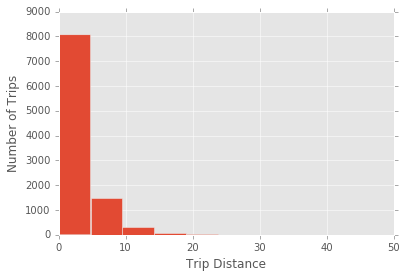

In [11]:
plt.hist(df_trip_distance.Trip_distance)
plt.ylabel('Number of Trips')
plt.xlabel('Trip Distance')
plt.show()

### We can say that in NYC most of the trips are less than 10 miles

# Question 3

## Part-1 - Report mean and median trip distance grouped by hour of day.

In [12]:
# Make a copy so that we don't change the original data frame
df_time = df.copy()

# Helper function to get hour of pickup datetime attribute
def get_hour(x):
    return x.split(' ')[1].split(':')[0]


### Mean Trip Distance grouped by hour of day.

In [13]:
pd.DataFrame(df_time.groupby(df_time['lpep_pickup_datetime'].apply(get_hour))
                 ['Trip_distance'].mean()).reset_index().rename(columns = {'lpep_pickup_datetime':'Hour'})

,Hour,Trip_distance
0,00,3.115276
1,01,3.017347
2,02,3.046176
3,03,3.212945
4,04,3.526555
5,05,4.133474
6,06,4.055149
7,07,3.284394
8,08,3.048450
9,09,2.999105


### Median Trip Distance grouped by hour of day.

In [14]:
pd.DataFrame(df_time.groupby(df_time['lpep_pickup_datetime'].apply(get_hour))
                 ['Trip_distance'].median()).reset_index().rename(columns = {'lpep_pickup_datetime':'Hour'})

,Hour,Trip_distance
0,00,2.20
1,01,2.12
2,02,2.14
3,03,2.20
4,04,2.36
5,05,2.90
6,06,2.84
7,07,2.17
8,08,1.98
9,09,1.96


## Part-2 - Identifying trips that originate or terminate at one of the NYC area airports and finding the count of how many transactions fit this criteria, the average fair, and any other interesting characteristics of these trips.

### By what I understood, to get the NYC area airports data we can check for feature column RateCodeID = 2,3,4. According to Data Dictionary :- 2 = JFK, 3 = Newark, 4 = Westchester .

### Rough sense of identifying trips that originate or terminate at one of the NYC area airports

In [15]:
# Make a copy so that we don't change the original data frame
df_airport = df.copy()
# RateCodeID array
codes = [2, 3, 4]
# Filtering dataframe to contain rows only for the above mentioned RateCodeID
df_airport = df_airport[df['RateCodeID'].isin(codes)]
df_airport.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
31,2,2015-09-01 00:07:12,2015-09-01 00:07:27,N,2,-73.844269,40.755165,-73.844650,40.755058,1,...,52.0,0.0,0.5,0.0,0.0,NaN,0.3,52.8,2,1.0
146,2,2015-09-01 00:21:08,2015-09-01 00:21:12,N,2,-73.930214,40.677612,-73.930214,40.677673,1,...,52.0,0.0,0.5,0.0,0.0,NaN,0.3,52.8,2,1.0
846,2,2015-09-01 00:57:46,2015-09-01 01:05:49,N,4,-73.735146,40.713020,-73.690865,40.704685,1,...,16.0,0.5,0.5,0.0,0.0,NaN,0.3,17.3,2,1.0
902,2,2015-09-01 00:14:55,2015-09-01 00:15:11,N,2,-73.946716,40.714317,-73.944954,40.714466,2,...,52.0,0.0,0.5,0.0,0.0,NaN,0.3,52.8,2,1.0
961,2,2015-09-01 00:14:55,2015-09-01 00:15:11,N,2,-73.946716,40.714317,-73.944954,40.714466,2,...,-52.0,0.0,-0.5,0.0,0.0,NaN,-0.3,-52.8,4,1.0


### Count of how many transactions fit the criteria of trips originating at one of NYC area airports 

In [16]:
num_trips = len(df_airport.index)
print("Number of transactions from or to NYC airports: {}".format(num_trips))

Number of transactions from or to NYC airports: 6477


### Average Fair of trips from or to NYC Airports and their comaprison to all trips

In [17]:
avg_fair_airport = df_airport['Total_amount'].mean()
avg_fair_original = df['Total_amount'].mean()

print("Average fair of trips from or to NYC airports: {}".format(avg_fair_airport))
print("Average fair of all trips in New York City: {}".format(avg_fair_original))

Average fair of trips from or to NYC airports: 58.8591832639
Average fair of all trips in New York City: 15.032145752


### Number of trips from or to all three airports to find the each airport's number of trips

In [18]:
# To get all data with a RateCodeID provided
def num_trips_code(code):
    return len(df_airport[df_airport['RateCodeID'] == code].index)
    

num_trips_jfk = num_trips_code(2)
num_trips_newark = num_trips_code(3)
num_trips_westchester = num_trips_code(4)

print("Number of trips from or to JFK Airport: {}".format(num_trips_jfk))
print("Number of trips from or to Newark Airport: {}".format(num_trips_newark))
print("Number of trips from or to Westchester Airport: {}".format(num_trips_westchester))

Number of trips from or to JFK Airport: 4435
Number of trips from or to Newark Airport: 1117
Number of trips from or to Westchester Airport: 925


# Question 4

## Part-1 - Derived variable for tip as a percentage of the total fare.


In [19]:
# Make a copy so that we don't change the original data frame
df_tip = df.copy()

### Since cash payment does not have tips so we can remove those trips and do some some data cleaning

In [20]:
# Since cash payment doesnot inlcude tips we can remove those rows
df_tip = df_tip[df_tip['Payment_type'] != 2]
df_tip.head()
# Filtering rows with Fare amount less then or equal to 0
df_tip = df_tip[(df_tip['Fare_amount'] > 0)]


### So now after looking at the data many samples still have missing tip values. We can give those samples a median value of all tips as it will help us build a better model

In [21]:
mean_tip = df_tip['Tip_amount'].mean()
# For tip  = 0 put median value of Tip_amount
df_tip.Tip_amount[(df_tip.Tip_amount) == 0.0] = mean_tip

### Let's now build our variable

In [22]:
# Tip amount calcluation
def tip_percentage_computation(x):
    return x['Tip_amount'] / (x['Fare_amount']) * 100

df_tip['Tip_percentage'] = df_tip.apply(tip_percentage_computation, axis=1)

In [23]:
# Showing top 5 samples
df_tip[['Tip_amount', 'Fare_amount', 'Tip_percentage']].head()

,Tip_amount,Fare_amount,Tip_percentage
0,1.950000,7.8,25.000000
1,2.602622,45.0,5.783605
2,0.500000,4.0,12.500000
5,1.360000,5.5,24.727273
6,2.602622,6.5,40.040340


## Part-2 - Build a model
### Before building our model let's clean some data and drop features which are not required

In [24]:
# Trip distance should be atleast greater then zero
df_tip = df_tip[(df_tip['Trip_distance'] > 0.0)]
# Drop Ehail Fee colum as it contains NaN
df_tip.drop('Ehail_fee', axis=1, inplace=True)
df_tip.drop('VendorID', axis=1, inplace=True)
df_tip.drop('Store_and_fwd_flag', axis=1, inplace=True)
df_tip.drop('RateCodeID', axis=1, inplace=True)
df_tip.drop('Pickup_longitude', axis=1, inplace=True)
df_tip.drop('Pickup_latitude', axis=1, inplace=True)
df_tip.drop('Dropoff_longitude', axis=1, inplace=True)
df_tip.drop('Dropoff_latitude', axis=1, inplace=True)
df_tip.drop('MTA_tax', axis=1, inplace=True)
df_tip.drop('Extra', axis=1, inplace=True)
df_tip.drop('improvement_surcharge', axis=1, inplace=True)
df_tip.drop('Trip_type ', axis=1, inplace=True) 

### Some helper functions to add time duration feature as it might be an important feature for our predictve model

In [25]:
# Helper function to Convert timestamp into time in seconds
def convert_time_seconds(x):
    return ((int(x.split(' ')[1].split(':')[0]) * 3600) +
            (int(x.split(' ')[1].split(':')[1]) * 60) + 
            int(x.split(' ')[1].split(':')[2]))

# Helper function to find time duration of trip from pickup and dropoff time
def trip_duration_computation(x):
    return x['dropoff_time_seconds'] - x['pickup_time_seconds']

### Making time duration fetaure

In [26]:
# Making two new columns of time in seconds
df_tip['pickup_time_seconds'] = df_tip['lpep_pickup_datetime'].apply(convert_time_seconds)
df_tip['dropoff_time_seconds'] = df_tip['Lpep_dropoff_datetime'].apply(convert_time_seconds)

# Trip duration column creation
df_tip['trip_duration'] = df_tip.apply(trip_duration_computation, axis=1)

# We don't need these columns now
df_tip.drop('Lpep_dropoff_datetime', axis=1, inplace=True)
df_tip.drop('lpep_pickup_datetime', axis=1, inplace=True)
df_tip.drop('pickup_time_seconds', axis=1, inplace=True)
df_tip.drop('dropoff_time_seconds', axis=1, inplace=True)
df_tip.drop('Tip_amount', axis=1, inplace=True)

In [27]:
# Showing top 5 smaples
df_tip.head()

,Passenger_count,Trip_distance,Fare_amount,Tolls_amount,Total_amount,Payment_type,Tip_percentage,trip_duration
2,1,0.59,4.0,0.0,5.80,1,12.500000,154
5,1,1.07,5.5,0.0,8.16,1,24.727273,281
6,1,1.43,6.5,0.0,7.80,1,40.040340,298
8,1,1.33,6.0,0.0,8.76,1,24.333333,284
11,1,0.70,4.0,0.0,6.36,1,26.500000,126


## Build the model using Scikit-Learn Random Forest Regressor

### Split data into training and test dataset

In [28]:
train_df_tip, test_df_tip = train_test_split(df_tip, test_size = 0.2)
# df_tip.drop('Total_amount', axis=1, inplace=True)

In [29]:
print(train_df_tip.shape, test_df_tip.shape)

((559196, 8), (139799, 8))


### Dividing training and testing data into features and target variable

In [30]:
X_full_train = train_df_tip.ix[:, train_df_tip.columns != 'Tip_percentage'].values 
y_full_train = train_df_tip['Tip_percentage'].values

X_full_test = test_df_tip.ix[:, test_df_tip.columns != 'Tip_percentage'].values 
y_full_test = test_df_tip['Tip_percentage'].values

n_samples_train = X_full_train.shape[0]
n_features_train = X_full_train.shape[1]

n_samples_test = X_full_test.shape[0]
n_features_test = X_full_test.shape[1]

# Printing number of samples
print("Number of training samples: {}, Number of training features: {} ".format(n_samples_train, n_features_train))
print("Number of testing samples: {}, Number of testing features: {} ".format(n_samples_test, n_features_test))

Number of training samples: 559196, Number of training features: 7 
Number of testing samples: 139799, Number of testing features: 7 


In [31]:
# X_full_train = X_full_train[:10000]
# y_full_train = y_full_train[:10000]

## Cross Validating model with all training data

In [32]:
# Estimate the score on the entire training dataset
estimator = RandomForestRegressor(random_state=0, n_estimators=256)
random_forest_score = cross_val_score(estimator, X_full_train, y_full_train)

In [33]:
print("Mean Score with the entire dataset = %.2f" % random_forest_score.mean())

Mean Score with the entire dataset = 0.93


### Fit the model with training data set

In [34]:
estimator.fit(X_full_train, y_full_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=256, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

### Calculate score of test data

In [36]:
estimator.score(X_full_test, y_full_test)

0.56483570110214554

# Question 5 Option A: Distributions

## Part-1 - Building derived variable representing the average speed over the course of a trip.

In [37]:
# Make a copy so that we don't change the original data frame
df_speed = df.copy()

In [38]:
# Making time columns in seconds
df_speed['pickup_time_seconds'] = df_speed['lpep_pickup_datetime'].apply(convert_time_seconds)
df_speed['dropoff_time_seconds'] = df_speed['Lpep_dropoff_datetime'].apply(convert_time_seconds)

In [39]:
# Making time duration column
df_speed['trip_duration_seconds'] = df_speed.apply(trip_duration_computation, axis=1)

In [40]:
# Claening some data to keep samples only with positive distances
# and with positive velocity
df_speed = df_speed[(df_speed['Trip_distance'] > 0.0)]
df_speed = df_speed[df_speed['trip_duration_seconds'] > 0.0]

In [41]:
df_speed.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,pickup_time_seconds,dropoff_time_seconds,trip_duration_seconds
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,0.50,0.0,NaN,0.3,5.80,1,1.0,110,264,154
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,0.00,0.0,NaN,0.3,6.30,2,1.0,156,402,246
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,0.00,0.0,NaN,0.3,6.30,2,1.0,14,260,246
5,2,2015-09-01 00:00:39,2015-09-01 00:05:20,N,1,-73.945297,40.808186,-73.937668,40.821198,1,...,1.36,0.0,NaN,0.3,8.16,1,1.0,39,320,281
6,2,2015-09-01 00:00:52,2015-09-01 00:05:50,N,1,-73.890877,40.746426,-73.876923,40.756306,1,...,0.00,0.0,NaN,0.3,7.80,1,1.0,52,350,298


## Average Speed Computation in m/s (meter/second)

In [42]:
# Helper function to compute 
def velocity_computation(x):
    return x['Trip_distance'] * 1609.344 / x['trip_duration_seconds']

df_speed['Average_speed'] = df_speed.apply(velocity_computation ,axis = 1)

In [43]:
df_speed.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,pickup_time_seconds,dropoff_time_seconds,trip_duration_seconds,Average_speed
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,0.0,NaN,0.3,5.80,1,1.0,110,264,154,6.165669
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,0.0,NaN,0.3,6.30,2,1.0,156,402,246,4.841116
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,0.0,NaN,0.3,6.30,2,1.0,14,260,246,3.990650
5,2,2015-09-01 00:00:39,2015-09-01 00:05:20,N,1,-73.945297,40.808186,-73.937668,40.821198,1,...,0.0,NaN,0.3,8.16,1,1.0,39,320,281,6.128107
6,2,2015-09-01 00:00:52,2015-09-01 00:05:50,N,1,-73.890877,40.746426,-73.876923,40.756306,1,...,0.0,NaN,0.3,7.80,1,1.0,52,350,298,7.722691


## Part-2  - Test to determine if the average trip speeds are materially the same in all weeks of September

In [44]:
# Helper function to compute the week number
def week_computation(x):
    day = int(x['lpep_pickup_datetime'].split(' ')[0].split('-')[2])
    if(day in range(1,8)):
        return 1
    elif(day in range(8,15)):
        return 2
    elif(day in range(15, 22)):
        return 3
    else:
        return 4

In [45]:
# Apply the wee computation function to make a new column with week number
df_speed['Week_number'] = df_speed.apply(week_computation, axis=1)

## Find the average speed for all weeks

In [46]:
pd.DataFrame(df_speed.groupby('Week_number')['Average_speed'].mean())

,Average_speed
Week_number,
1,7.378875
2,6.895124
3,6.943773
4,7.525499


### This shows that  in the first week and last week the trips tend to have more average speed.

## Part-3 - Average Trip Speed as a function of time of day?

In [48]:
pd.DataFrame((df_speed.groupby(df_speed['lpep_pickup_datetime']
                        .apply(lambda x: int(x.split(' ')[1].split(':')[0])))['Average_speed'].mean())
                             .reset_index().rename(columns = {'lpep_pickup_datetime':'Hour'}))

,Hour,Average_speed
0,0,8.001555
1,1,8.163479
2,2,8.448125
3,3,8.711868
4,4,8.915445
5,5,13.338739
6,6,9.531322
7,7,7.192546
8,8,7.054849
9,9,6.751018


### From this we can say that trip Average Speed is usually fast when there is less traffic during early morning and late night which is what happens in real life. 
### Unsurprisingly during Earlymorning at 5 AM and 6 AM, the trips Average Speed is high.